# Statistical Modeling of Powerball data
There are three main steps to Statistical modeling:
- Write down the model
  - Prior and likelihood functions
- Compute the Posterior
  - Sampling or Inference
- Check the model
  - Prior Sensitivity
  - Reliability/accuracy in relation to observed data

A powerball ticket has five distinct numbers drawn from 1 to 69, and a sixth "powerball number" drawn independently. Here we are going to model the distribution of the smallest number in the powerball lottery tickets. 

In [101]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
import pandas as pd

## Load dataset
Peek into the data - curiosity helps build intuition
Intuition yields a prior (required for probabilistic modeling).


In [102]:
df_train = pd.read_csv('./pb/pb_asc_x1x5_x6.csv', header=None, names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df_train.head()

,x1,x2,x3,x4,x5,x6
0,16,30,41,48,53,16
1,1,26,41,50,57,11
2,23,33,42,46,59,4
3,2,18,19,22,63,19
4,10,16,40,52,55,17


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1242e3cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1258578d0>]], dtype=object)

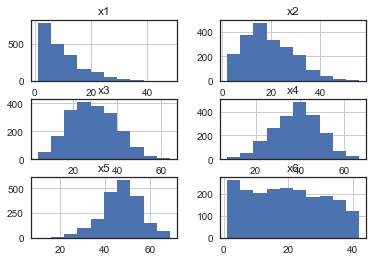

In [103]:
ranges = { i : (df_train[i].min(), df_train[i].max(), df_train[i].max() - df_train[i].min()) for i in df_train.columns}
df_train.hist()

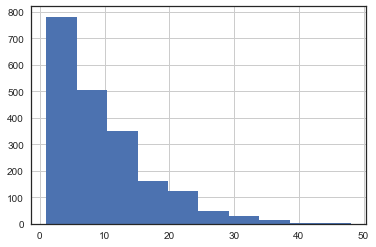

In [104]:
df_train['x1'].hist()

__**That looks like a BetaBinomial discrete distribution with support over a specifiable range (0-47)**__. Use [Wikipedia: List of Probability distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124fb7d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122c23d90>]], dtype=object)

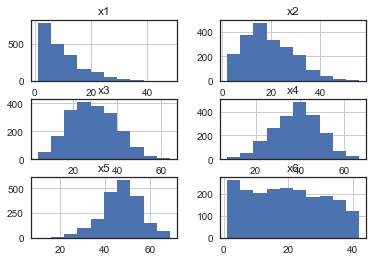

In [105]:
#Now they are all shifted down to zero
df_train.hist()

In [106]:
ranges

{'x1': (1, 48, 47),
 'x2': (2, 56, 54),
 'x3': (4, 64, 60),
 'x4': (7, 67, 60),
 'x5': (10, 69, 59),
 'x6': (1, 42, 41)}

In [107]:
df_train['x3'].min(), df_train['x3'].max(), df_train['x5'].min(), df_train['x5'].max()

(4, 64, 10, 69)

### Step 1 - Build the Model
The likelihood function is assumed to be a BetaBinomial. How did we arrive that? First study a list of probability functions, wikipedia is a great starter source. Then notice that our model has a definite support. What does that mean? That means the variable X1 is defined in a specific range. Also, X1 is discrete. So now one keeps rummaging for distributions that appear to have similar profile as the data we like to model including support and type.
In this case we find that BetaBinomial appears to fit the bill. It is definitely possible that one could other equally feasible probability distributions. In fact, that is part of the adventure of statistical modeling:
- positing the modeling question in interesting ways
- so as to find easily approximateable distributions

In [108]:
X1 = df_train['x1'] - ranges['x1'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.3, upper=2) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta

    # Adjust for 0-based for BetaBinomial distribution
    x1_post = pm.BetaBinomial('x1_post', alpha=alphap, beta=betap, 
                n=ranges['x1'][2], #range for x1
                observed=X1
          ) #Parameterized Likelihood


## Step 2 - Compute the Posterior
This is either done through sampling or inference. In case of MCMC family of sampling, the choices are - Metropolis, HMC, NUTS. 
Variational Inference converts the approximation problem into an optimization problem of minimizing KL Divergence between the posterior and a known suggested distribution _q_. Variational Inference, though was known for decades, recently got a boost from the recent techniques of Automatic Differentiation Variational Inference (ADVI). Variational Inferences are usually rapid, but suffer from accuracy.

Here we use NUTS sampler

100%|██████████| 5500/5500 [00:24<00:00, 224.01it/s]


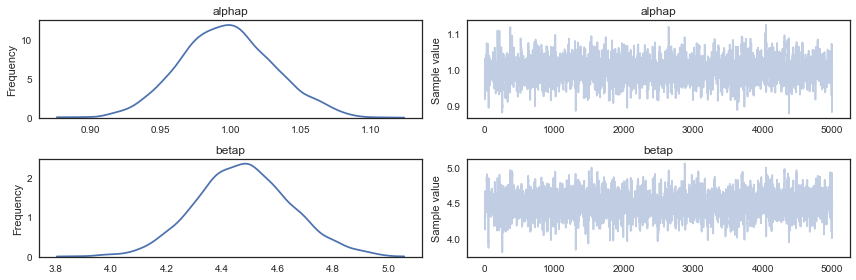

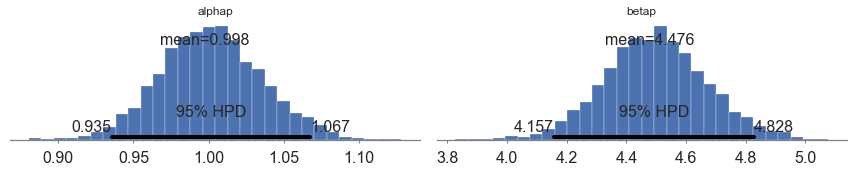

In [109]:
with bb:
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99)) #NUTS sampler, only accept > target
    pm.traceplot(trace) #show me the parameters, alpha
    #pm.energyplot(trace) #the energy plot 
    pm.plot_posterior(trace, varnames=['alphap', 'betap']) #plot the posterior with mean, HPD

In [110]:
#Divergences
trace['diverging'].nonzero()[0].size * 1.0 / len(trace)


0.0

## Step 3 - Check the Model
- Use the Posterior Predictive Check, ppc
- Plot observed and simulated
- Check model sensitivity to prior

In [111]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)


100%|██████████| 500/500 [00:00<00:00, 3274.67it/s]


### Plot observed and simulated


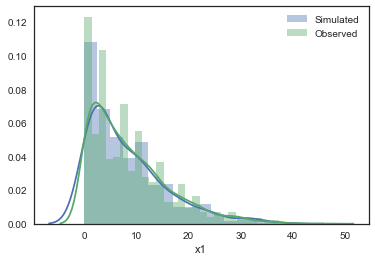

In [112]:
sns.distplot(ppc['x1_post'], label='Simulated')
sns.distplot(X1, label='Observed')
plt.legend()

_Looks quite promising_

### Prior sensitivity
- Same model with different priors (note the use of HalfCauchy and Exponential priors)
- Check the posterior with the previous posterior
- Notice the Highest Posterior Density region of the parameters(HPD)

100%|██████████| 5500/5500 [00:17<00:00, 320.73it/s]


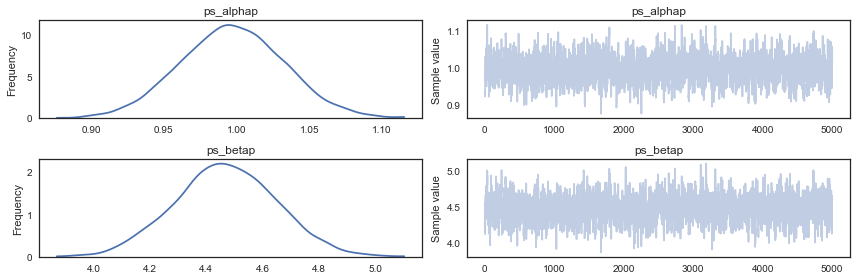

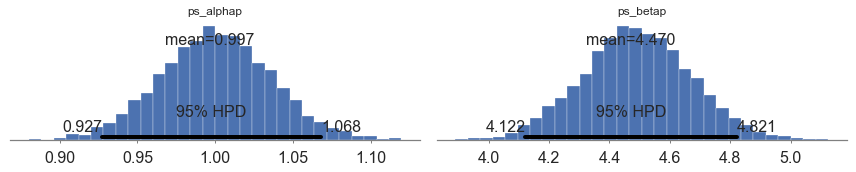

In [113]:
#Prior sensitivity
with pm.Model() as prior_sensitivity:
    alphap = pm.HalfCauchy('ps_alphap', beta=5) #alpha is assumed to be HalfCauchy
    betap = pm.Exponential('ps_betap', lam=.2) #beta is assumed to be exponential
    ps_x1 = pm.BetaBinomial('ps_x1', alpha=alphap, beta=betap, n=ranges['x1'][2], observed=X1)
    ps_trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.traceplot(ps_trace)
    #pm.energyplot(ps_trace)
    pm.plot_posterior(ps_trace, varnames=['ps_alphap', 'ps_betap'])

**__That posterior is the same as the previous one (except for minor numerical precision differences)__**
It further confirms / validates our model.
Now, one could apply the same model for each of x2, x3, x4, and x5, with varying discrete intervals as support.
For x6 we could consider a categorical distribution (or a similar BetaBinomial as for x1-x5).

#### Fit the data for X2

100%|██████████| 5500/5500 [00:24<00:00, 221.14it/s]


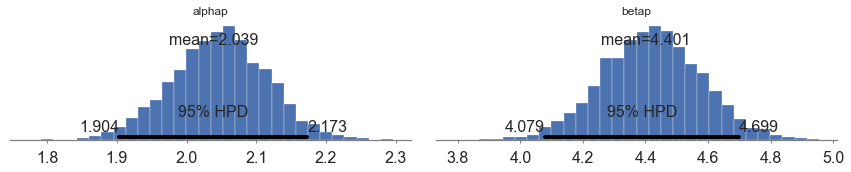

In [153]:
#Adjust for 0-based for BetaBinomial distribution
X2 = df_train['x2'] - ranges['x2'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=3) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x2 = pm.BetaBinomial('x2_post', alpha=alphap, beta=betap, n=ranges['x2'][2], 
                         observed=X2) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)



100%|██████████| 500/500 [00:00<00:00, 3184.69it/s]


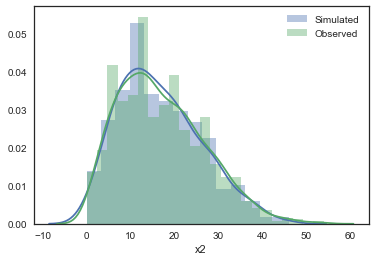

In [154]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x2_post'], label='Simulated')
    sns.distplot(X2, label='Observed')
    plt.legend()

_Now that looks like a very good fit_

#### Fit for X3

100%|██████████| 5500/5500 [00:26<00:00, 203.86it/s]


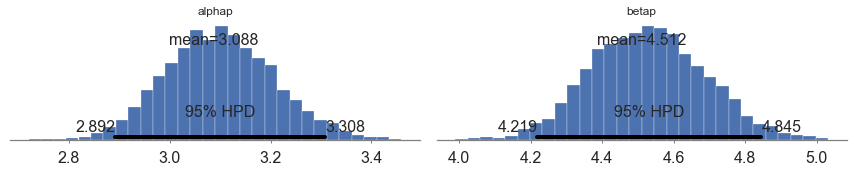

In [155]:
#Adjust for 0-based for BetaBinomial distribution
X3 = df_train['x3'] - ranges['x3'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=4) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x3 = pm.BetaBinomial('x3_post', alpha=alphap, beta=betap, n=ranges['x3'][2], 
                         observed=X3) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)



100%|██████████| 500/500 [00:00<00:00, 3148.48it/s]


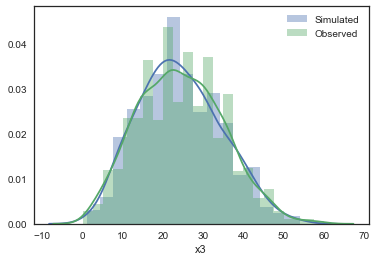

In [156]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x3_post'], label='Simulated')
    sns.distplot(X3, label='Observed')
    plt.legend()

#### Fit for X4

100%|██████████| 5500/5500 [00:32<00:00, 168.39it/s]


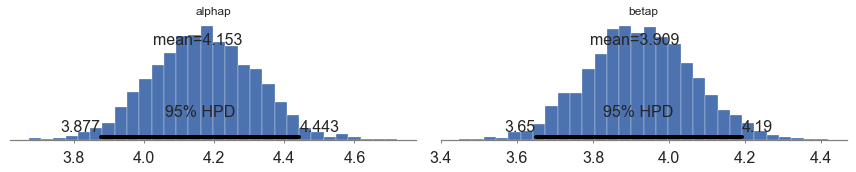

In [158]:
#Adjust for 0-based for BetaBinomial distribution
X4 = df_train['x4'] - ranges['x4'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=5) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x4 = pm.BetaBinomial('x4_post', alpha=alphap, beta=betap, n=ranges['x4'][2], 
                         observed=X4) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 500/500 [00:00<00:00, 3153.80it/s]


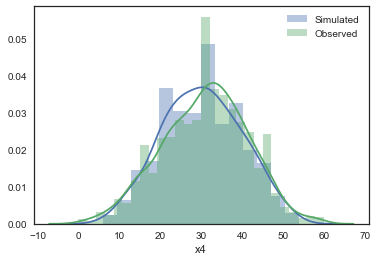

In [159]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x4_post'], label='Simulated')
    sns.distplot(X4, label='Observed')
    plt.legend()

#### Fit for X5

100%|██████████| 5500/5500 [00:28<00:00, 191.33it/s]


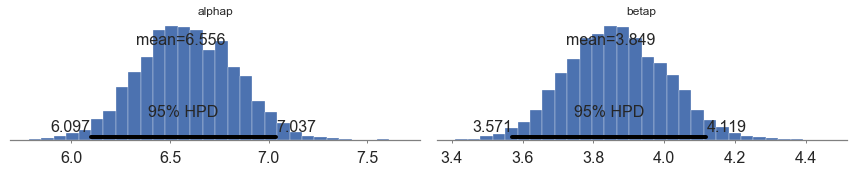

In [162]:
#Adjust for 0-based for BetaBinomial distribution
X5 = df_train['x5'] - ranges['x5'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=2., upper=8) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x5 = pm.BetaBinomial('x5_post', alpha=alphap, beta=betap, n=ranges['x5'][2], 
                         observed=X5) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 1000/1000 [00:00<00:00, 3243.07it/s]


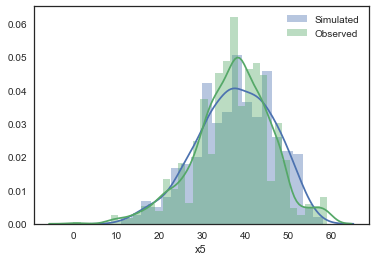

In [164]:
with bb:
    ppc = pm.sample_ppc(trace, samples=1000)
    sns.distplot(ppc['x5_post'], label='Simulated')
    sns.distplot(X5, label='Observed')
    plt.legend()

## Miscellaneous

Assigned Metropolis to x2_post
100%|██████████| 8500/8500 [00:01<00:00, 5464.23it/s]


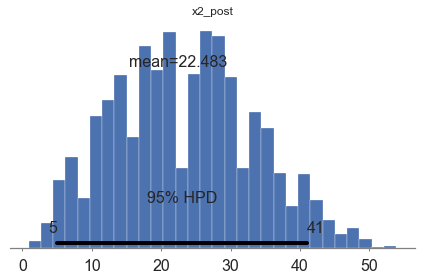

In [147]:
with pm.Model():
    x2 = pm.BetaBinomial('x2_post', alpha=3., beta=4., n=ranges['x2'][2])
    trace = pm.sample(10000)
    pm.plot_posterior(trace)


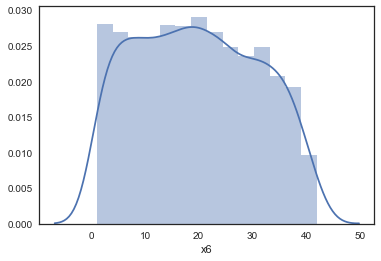

In [166]:
sns.distplot(df_train['x6'])